In [1]:
import numpy as np
import gym
from gym import spaces
from itertools import count
import matplotlib.pyplot as plt
%matplotlib inline

# Multi-Agent GridWorld Environment

In [2]:
class GridWorld(gym.Env):
    metadata = { 'render.modes': ['human', 'rgb_array'] }
    
    def __init__(self, n_agents, size=5):
        self._size = size #grid-size
        self.n_agents = n_agents #nof-of-agents
        self.observation_space = spaces.Discrete(self._size*self._size)
        self.action_space = spaces.Discrete(4)
        self._timestep = 0 #current-timestep
        self.max_timesteps = 500 #maximum timestep
        
    def reset(self):
        self.target_pos = [3,3] #np.random.randint(self._size, size=2).tolist() goal location
        self.agent_pos = [[1,0], [0,4]] #agent initial location
#         self.agent_pos = []
#         for i in range(self.n_agents):
#             self.agent_pos.append( np.random.randint(self._size, size=2).tolist() )
        self.done = [False for i in range(self.n_agents)] 
        self._timestep = 0 
        self.reset_reward_grid()
        return self.agent_pos
    
    def reset_reward_grid(self):
        self.target_reward = 20 #goal reward
        self._step_cost = -0.1 #step reward (penalty)
        self._outbound_cost = -1 #out of grid moves reward(penalty)
        self.reward_grid = self._step_cost * np.ones((self._size, self._size))
        target_x, target_y = tuple(self.target_pos) 
        self.reward_grid[target_x][target_y] = self.target_reward
        for x,y in [(-1,0), (1,0), (0,1), (0,-1)]:
            if 0 <= target_x+x < self._size and 0 <= target_y+y < self._size:
                self.reward_grid[target_x+x][target_y+y] = self.target_reward/4
        for x,y in [(-1,-1), (1,-1), (-1,1), (1,1)]:
            if 0 <= target_x+x < self._size and 0 <= target_y+y < self._size:
                self.reward_grid[target_x+x][target_y+y] = self.target_reward/8
        
    def step(self, action):
        self._timestep += 1 #increase timestep
        rewards = [0 for i in range(self.n_agents)]
        old_pos = self.agent_pos.copy()
        
        #for each agent
        for i in range(self.n_agents):
            if self.done[i]:
                continue
            elif action[i] == 0: #up
                self.agent_pos[i][0] -= 1
            elif action[i] == 1: #down
                self.agent_pos[i][0] += 1
            elif action[i] == 2: #left
                self.agent_pos[i][1] -= 1
            elif action[i] == 3: #right
                self.agent_pos[i][1] += 1
            before_clip = self.agent_pos[i].copy()
            self.agent_pos[i] = np.clip(self.agent_pos[i], 0, self._size-1).tolist()
            if self.agent_pos[i] == before_clip:
                rewards[i] = self.reward_grid[tuple(self.agent_pos[i])]
                self.reward_grid[tuple(self.agent_pos[i])] = self._step_cost
            else:
                rewards[i] = self._outbound_cost
        
        #if time steps exceeded
        if self._timestep >= self.max_timesteps:
            self.done = [True for i in range(self.n_agents)]
        else:
            self.done = [self.agent_pos[i]==self.target_pos for i in range(self.n_agents)]
        observation = self.agent_pos.copy()
        info = {}
        return observation, rewards, self.done, info
        
    def render(self):
        state = np.zeros((self._size, self._size))
        for i in range(self.n_agents):
            state[tuple(self.agent_pos[i])] = -50*(i+1)
        state[tuple(self.target_pos)] = 500
        return plt.imshow(state)
    
    def render_reward_grid(self):
        return plt.imshow(self.reward_grid, cmap='hot')

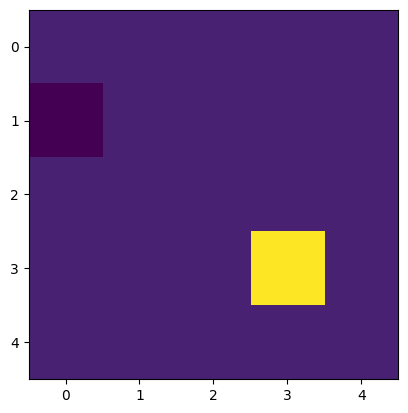

In [5]:
g = GridWorld(n_agents=1)
g.reset()
g.render()

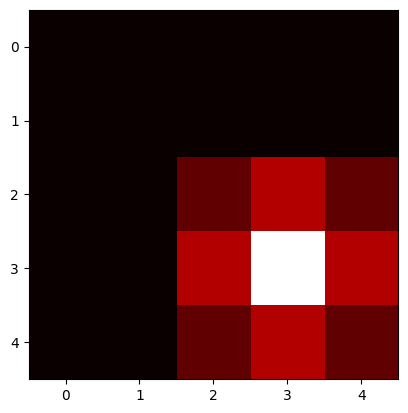

In [6]:
g.render_reward_grid()

# Tabular Method: Q-Learning

In [11]:
class QLearning:
    
    def __init__(self, env):
        self.env = env
        self.learning_rate = 0.01
        self.gamma = 0.95
        
    def reset(self):
        self.env.reset()
        self.q_table = np.random.rand(self.env.observation_space.n, self.env.action_space.n)
        terminal_state = self.state_to_index(self.env.target_pos)
        self.q_table[terminal_state][:] = 0
        self.epsilon = 1
        
    def state_to_index(self, pos):
        return pos[0]*self.env._size + pos[1]
    
    def choose_action(self, states):
        if np.random.random() < self.epsilon:
            return np.random.randint(self.env.action_space.n, size=self.env.n_agents).tolist()
        else:
            return [np.argmax(self.q_table[s]) for s in states]
        
    def train(self, num_episodes=3000):
        self.epsilon = 1
        self.epsilon_values = []
        self.reward_per_episode = []
        for _ in range(num_episodes):
            self.env.reset()
            done = self.env.done
            episode_reward = 0
            curr_states = [self.state_to_index(pos) for pos in self.env.agent_pos]
            for t in count():
                actions = self.choose_action(curr_states)
                obs, reward, done, info = self.env.step(actions)
                episode_reward += self.gamma**t * np.sum(reward)
                next_states = [self.state_to_index(pos) for pos in self.env.agent_pos]
                for i in range(self.env.n_agents):
                    if done[i]:
                        continue
                    self.q_table[curr_states[i]][actions[i]] += self.learning_rate * \
                    ( reward[i] + self.gamma*np.max(self.q_table[next_states[i]]) - self.q_table[curr_states[i]][actions[i]] )
                curr_states = next_states
                if np.all(done):
                    break
            self.reward_per_episode.append(episode_reward)
            self.epsilon_values.append(self.epsilon)
            self.epsilon *= 0.01 ** (1/num_episodes)
        self.train_plot()
        
    def train_plot(self):
        plt.figure(figsize=(8,4))
        plt.plot(self.epsilon_values)
        plt.xlabel("Episodes", fontsize=8)
        plt.ylabel("Epsilon Value", fontsize=8)
        plt.show()
        plt.figure(figsize=(8,4))
        plt.plot(self.reward_per_episode)
        plt.xlabel("Episodes", fontsize=8)
        plt.ylabel("Total Reward", fontsize=8)
        plt.show()
        
    def evaluate(self, num_episodes=5):
        self.epsilon = 0
        self.eval_reward_per_episode = []
        for _ in range(num_episodes):
            obs = self.env.reset()
            print("obs:", obs)
            done = self.env.done
            episode_reward = 0
            for t in count():
                curr_states = [self.state_to_index(pos) for pos in self.env.agent_pos]
                actions = self.choose_action(curr_states)
                obs, reward, done, info = self.env.step(actions)
                print("obs:", obs, "\treward:", reward, "\tdone:", done)
                episode_reward += self.gamma**t * np.sum(reward)
                if np.all(done):
                    break
            self.eval_reward_per_episode.append(episode_reward)
            print("Episode Reward:", episode_reward)
        # self.eval_plot()
        
    def eval_plot(self):
        plt.figure(figsize=(8,4))
        plt.plot(self.eval_reward_per_episode)
        plt.xlabel("Episodes", fontsize=8)
        plt.ylabel("Total Reward", fontsize=8)
        plt.show()

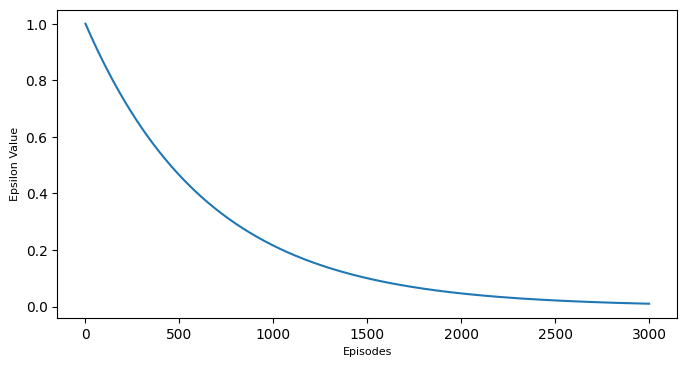

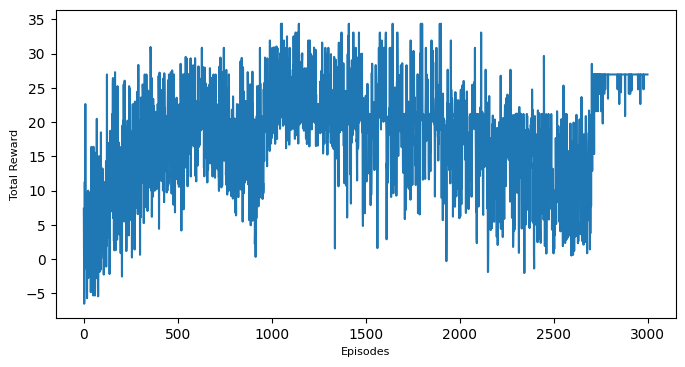

In [12]:
q = QLearning( env=GridWorld(n_agents=1) )
q.reset()
q.train()

In [14]:
q.evaluate(1)

obs: [[1, 0], [0, 4]]
obs: [[1, 1], [0, 4]] 	reward: [-0.1] 	done: [False]
obs: [[1, 2], [0, 4]] 	reward: [-0.1] 	done: [False]
obs: [[2, 2], [0, 4]] 	reward: [2.5] 	done: [False]
obs: [[2, 3], [0, 4]] 	reward: [5.0] 	done: [False]
obs: [[2, 4], [0, 4]] 	reward: [2.5] 	done: [False]
obs: [[3, 4], [0, 4]] 	reward: [5.0] 	done: [False]
obs: [[3, 3], [0, 4]] 	reward: [20.0] 	done: [True]
Episode Reward: 26.955133124999993


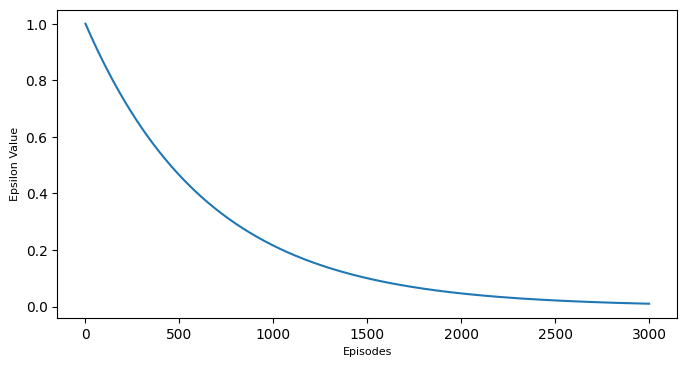

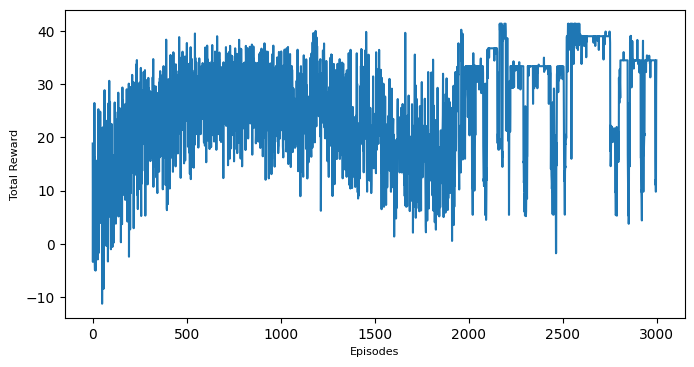

In [15]:
q = QLearning( env=GridWorld(n_agents=2) )
q.reset()
q.train()

In [16]:
q.evaluate(1)

obs: [[1, 0], [0, 4]]
obs: [[2, 0], [1, 4]] 	reward: [-0.1, -0.1] 	done: [False, False]
obs: [[2, 1], [2, 4]] 	reward: [-0.1, 2.5] 	done: [False, False]
obs: [[2, 2], [3, 4]] 	reward: [2.5, 5.0] 	done: [False, False]
obs: [[2, 3], [4, 4]] 	reward: [5.0, 2.5] 	done: [False, False]
obs: [[2, 4], [4, 3]] 	reward: [-0.1, 5.0] 	done: [False, False]
obs: [[3, 4], [3, 3]] 	reward: [-0.1, 20.0] 	done: [False, True]
obs: [[4, 4], [3, 3]] 	reward: [-0.1, 0] 	done: [False, True]
obs: [[4, 3], [3, 3]] 	reward: [-0.1, 0] 	done: [False, True]
obs: [[3, 3], [3, 3]] 	reward: [-0.1, 0] 	done: [True, True]
Episode Reward: 34.45869881944921


In [21]:
q = QLearning( env=GridWorld(n_agents=3) )
q.reset()
q.train()

IndexError: list index out of range